In [ ]:
# !python -m spacy download fr_core_news_sm

In [1]:
import torch
from torch import nn
import os
from torchtext.data.utils import get_tokenizer
import torch.nn.functional as F
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm import tqdm
import random
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from unidecode import unidecode
import numpy as np
import pandas as pd
from matplotlib import ticker

/home/jakub/anaconda3/envs/transformers/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/jakub/anaconda3/envs/transformers/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/jakub/anaconda3/envs/transformers/lib/python3.12/site-packages/torchtext/utils.py:4: 

In [28]:
# Normalize string
def normalizeString(s):
    s = unidecode(s.lower())
    return s

In [162]:
SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>'] # UNK for unknown words
NUMBER_OF_SENTENCES = 1000

In [29]:
# Open data file and read lines
with open("./data/pol.txt") as f:
    lines = f.readlines()

# For each line split it by TAB
for i, line in enumerate(lines):
    line = line.split('\t')
    lines[i] = [normalizeString(line[0]), normalizeString(line[1])]



In [37]:
# Print example line
print(lines[random.randint(0, 1000)])

['be strong.', 'badz silny.']


In [38]:
# Create tokenizers
pl_tokenizer = spacy.load("pl_core_news_sm")
en_tokenizer = spacy.load("en_core_web_sm")

In [46]:
# Test tokenizer
tokens = pl_tokenizer(lines[0][1])
print('Number of tokens:', len(tokens))
for token in tokens:
    print(token)

Number of tokens: 2
idz
.


In [118]:
# Lists for storing Polish and English sentences
pl_list = []
en_list = []

# Lists for storing number of tokens in sentences 
pl_lengths = []
en_lengths = []

for line in tqdm(lines[:NUMBER_OF_SENTENCES]):
    # Tokenize sentences
    en_tokens = en_tokenizer(line[0])
    pl_tokens = pl_tokenizer(line[1])

    # Concatenate tokens to lists (each tokenized sentence is different element in the list)
    pl_list += pl_tokens
    en_list += en_tokens

    # Append number of tokens in sentences
    pl_lengths.append(len(pl_tokens))
    en_lengths.append(len(en_tokens))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:18<00:00, 52.97it/s]


In [124]:
# Split sentences into string tokens 
pl_token_list = [str(token) for token in pl_list]
en_token_list = [str(token) for token in en_list]

# Counter object works similar to dictionary in which each element is key and value is number of times this element is present
pl_counter = Counter()
en_counter = Counter()

for token in pl_token_list:
    pl_counter[token] += 1
for token in en_token_list:
    en_counter[token] += 1

In [129]:
# Extract 10 most common tokens
en_most_common = en_counter.most_common(10)
pl_most_common = pl_counter.most_common(10)

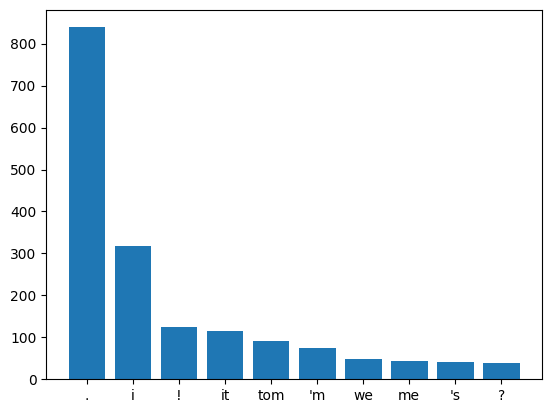

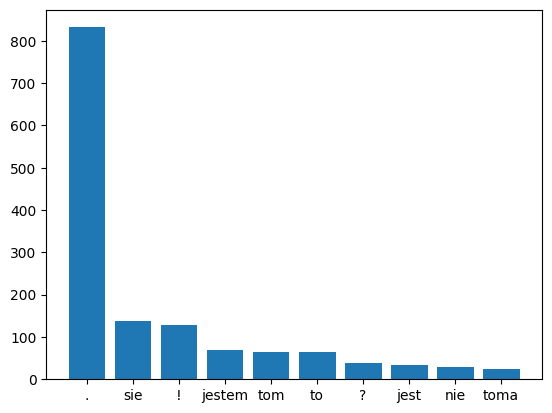

In [143]:
# Bar plots of most common tokens
plt.bar([token[0] for token in en_most_common], [token[1] for token in en_most_common])
plt.show()
plt.bar([token[0] for token in pl_most_common], [token[1] for token in pl_most_common])
plt.show()

In [144]:
# Example tokens
print('Polish tokens: ', pl_list[:20])
print('English tokens: ', en_list[:20])

Polish tokens:  [idz, ., czesc, ., uciekaj, !, biegnij, ., uciekaj, ., kto, ?, o, ,, dziamdzia, zaprzala, jej, szadz, !, lal]
English tokens:  [go, ., hi, ., run, !, run, ., run, ., who, ?, wow, !, wow, !, duck, !, fire, !]


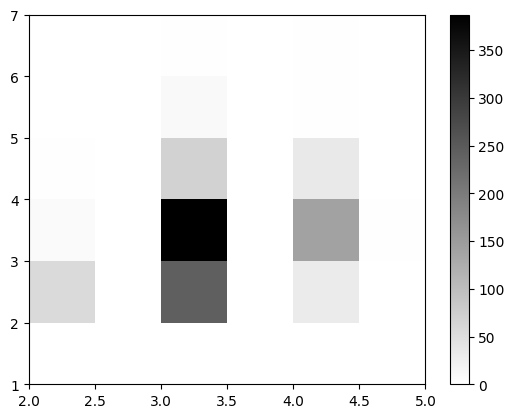

In [155]:
# Sentence lengths comparison
plt.hist2d(en_lengths, pl_lengths, cmap='binary', bins=6)
plt.colorbar()

In [183]:
# Create torchtext Vocabs from lists of tokens
en_vocab = build_vocab_from_iterator([en_token_list], specials=SPECIALS)
pl_vocab = build_vocab_from_iterator([pl_token_list], specials=SPECIALS)

In [184]:
VALID_PCT = 0.1
TEST_PCT  = 0.1

train_data = []
valid_data = []
test_data = []

random.seed(6547)
for (en, pl) in lines[:NUMBER_OF_SENTENCES]:
    # Tokenizes words, takes each token and gets item from torchtext Vocab. __getitem__ from torchtext Vocab returns index of this token
    en_tensor_ = torch.tensor([en_vocab[str(token)] for token in en_tokenizer(en)])
    pl_tensor_ = torch.tensor([pl_vocab[str(token)] for token in pl_tokenizer(pl)]) 
    
    # Gets random number from 0 to 1 and adds the token to the appropriate dataset
    random_draw = random.random()
    if random_draw <= VALID_PCT:
        valid_data.append((en_tensor_, pl_tensor_))
    elif random_draw <= VALID_PCT + TEST_PCT:
        test_data.append((en_tensor_, pl_tensor_))
    else:
        train_data.append((en_tensor_, pl_tensor_))


print(f"""
  Training pairs: {len(train_data):,}
Validation pairs: {len(valid_data):,}
      Test pairs: {len(test_data):,}""")


  Training pairs: 815
Validation pairs: 74
      Test pairs: 111


In [180]:
# Print comparison of one sentence
tokens = pl_tokenizer(lines[0][1])
print('Number of tokens:', len(tokens))
print('List of tokens:', [token for token in tokens])
print('List of vocab tensor tokens:', train_data[0][1])

Number of tokens: 2
List of tokens: [idz, .]
List of vocab tensor tokens: tensor([18,  0])


In [189]:
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

# Checks if both vocabs have the same index for special characters
for en_id, pl_id in zip(en_vocab.lookup_indices(SPECIALS), pl_vocab.lookup_indices(SPECIALS)):
  assert en_id == pl_id

In [193]:
def generate_batch(data_batch):
    '''
    Prepare English and Polish examples for batch-friendly modeling by appending
    BOS/EOS tokens to each, stacking the tensors, and filling trailing spaces of
    shorter sentences with the <pad> token. To be used as the collate_fn in the
    English-to-French DataLoader.

    Input: 
    - data_batch, an iterable of (English, Polish) tuples from the datasets 
      created above

    Outputs
    - en_batch: a (max length X batch size) tensor of English token IDs
    - pl_batch: a (max length X batch size) tensor of Polish token IDs 
    '''
    en_batch, pl_batch = [], []

    # Add BOS and EOS at the beggining and end of sentences
    for (en_item, pl_item) in data_batch:
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
        pl_batch.append(torch.cat([torch.tensor([BOS_IDX]), pl_item, torch.tensor([EOS_IDX])], dim=0))

    # Pad the sentences so that they have the same length
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=False)
    pl_batch = pad_sequence(pl_batch, padding_value=PAD_IDX, batch_first=False)

    return en_batch, pl_batch

In [194]:
BATCH_SIZE = 16

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)


In [203]:
# Check how sentences look in natural language
for i, (en_id, pl_id) in enumerate(train_iter):
    print('English:', ' '.join([en_vocab.lookup_token(idx) for idx in en_id[:, 0]]))
    print('French:', ' '.join([pl_vocab.lookup_token(idx) for idx in pl_id[:, 0]]))
    if i == 4: 
        break
    else:
        print()

English: <bos> i 'm sad . <eos>
French: <bos> jestem smutny . <eos> <pad>

English: <bos> tom drank . <eos> <pad> <pad>
French: <bos> tom pil . <eos> <pad> <pad>

English: <bos> they left . <eos>
French: <bos> wyszli . <eos> <pad>

English: <bos> i drove . <eos> <pad>
French: <bos> prowadzilem . <eos> <pad> <pad> <pad> <pad>

English: <bos> get tom . <eos> <pad>
French: <bos> zabierz toma . <eos> <pad>


In [205]:
MAX_SENTENCE_LENGTH = 20

In [206]:
ENCODER_EMBEDDING_DIM = 256
DECODER_EMBEDDING_DIM = 256
ENCODER_HIDDEN_DIM = 256
DECODER_HIDDEN_DIM = 256
SAVE_DIR = os.path.join(".", "models")

In [ ]:
class BahdanauEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout_p):
        super().__init__()
        self.input_dim = input_dim # Dictionary size
        self.embedding_dim = embedding_dim # Size of embedding vector
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(input_dim, embedding_dim) 

        #Gated recurrent unit
        self.gru = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True) 
        '''
        For GRU parameters stand for:
            * embedding dim - number of expected features in input x
            * encoder_hidden_dim - number of features in hidden state h
        '''

        self.linear = nn.Linear(encoder_hidden_dim*2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, hidden = self.gru(embedded)
        hidden = torch.tanh(self.linear(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

### Train Bahdanau seq2seq

In [216]:
class MultipleOptimizer(object):
    def __init__(self, *op):
        self.optimizers = op
        
    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()
    
    def step(self):
        for op in self.optimizers:
            op.step()

In [217]:
def train(model, iterator, optimizer, loss_fn, device, clip=None):
    model.train()
    if model.device != device:
        model = model.to(device)
        
    epoch_loss = 0
    with tqdm(total=len(iterator), leave=False) as t:
        for i, (src, tgt) in enumerate(iterator):
            src_mask = (src != PAD_IDX).to(device)
            src = src.to(device)
            tgt = tgt.to(device)
            
            optimizer.zero_grad()
            
            output = model(src, tgt, src_mask)
            
            loss = loss_fn(output[1:].view(-1, output.shape[2]),
                           tgt[1:].view(-1))
            
            loss.backward()
            
            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optimizer.step()
            epoch_loss += loss.item()
            
            avg_loss = epoch_loss / (i+1)
            t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                          ppl='{:05.3f}'.format(np.exp(avg_loss)))
            t.update()
            
    return epoch_loss / len(iterator)

In [218]:
def evaluate(model, iterator, loss_fn, device):
    model.eval()
    if model.device != device:
        model = model.to(device)
        
    epoch_loss = 0
    with torch.no_grad():
        with tqdm(total=len(iterator), leave=False) as t:
            for i, (src, tgt) in enumerate(iterator):
                src_mask = (src != PAD_IDX).to(device)
                src = src.to(device)
                tgt = tgt.to(device)
                
                output = model(src, tgt, src_mask, teacher_forcing_ratio=0)
                loss = loss_fn(output[1:].view(-1, output.shape[2]),
                               tgt[1:].view(-1))
                
                epoch_loss += loss.item()
                
                avg_loss = epoch_loss / (i+1)
                t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                              ppl='{:05.3f}'.format(np.exp(avg_loss)))
                t.update()
    
    return epoch_loss / len(iterator)

In [224]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
enc = BahdanauEncoder(len(en_vocab), ENCODER_EMBEDDING_DIM,
                        ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM, 0.15)
attn = BahdanauAttentionQKV(DECODER_HIDDEN_DIM)
dec = BahdanauDecoder(len(pl_vocab), DECODER_EMBEDDING_DIM,
                        ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM, attn, 0.15)
seq2seq = BahdanauSeq2Seq(enc, dec, device)


In [225]:
def count_params(model, return_int=False):
    params = sum([torch.prod(torch.tensor(x.shape)).item() for x in model.parameters() if x.requires_grad])
    if return_int:
        return params
    else:
        print("There are {:,} trainable parameters in this model.".format(params))

In [226]:
count_params(seq2seq)

There are 3,151,216 trainable parameters in this model.


In [227]:
enc_optim = torch.optim.AdamW(seq2seq.encoder.parameters(), lr=1e-4)
dec_optim = torch.optim.AdamW(seq2seq.decoder.parameters(), lr=1e-4)
optims = MultipleOptimizer(enc_optim, dec_optim)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [232]:
N_EPOCHS = 20
CLIP = 10 # clipping value, or None to prevent gradient clipping
EARLY_STOPPING_EPOCHS = 2

if not os.path.exists(SAVE_DIR):
    print(f"Creating directory {SAVE_DIR}")
    os.mkdir(SAVE_DIR)
    
model_path = os.path.join(SAVE_DIR, 'bahdanau_en_fr.pt')
bahdanau_metrics = {}
best_valid_loss = float("inf")
early_stopping_count = 0
for epoch in tqdm(range(N_EPOCHS), leave=False, desc="Epoch"):
    train_loss = train(seq2seq, train_iter, optims, loss_fn, device, clip=CLIP)
    valid_loss = evaluate(seq2seq, valid_iter, loss_fn, device)
    
    if valid_loss < best_valid_loss:
        tqdm.write(f"Checkpointing at epoch {epoch + 1}")
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), model_path)
        early_stopping_count = 0
    else:
        early_stopping_count += 1
    
    bahdanau_metrics[epoch+1] = dict(
        train_loss = train_loss,
        train_ppl = np.exp(train_loss),
        valid_loss = valid_loss,
        valid_ppl = np.exp(valid_loss)
    )
    
    if early_stopping_count == EARLY_STOPPING_EPOCHS:
        tqdm.write(f"Early stopping triggered in epoch {epoch + 1}")
        break

Epoch:   5%|▌         | 1/20 [00:04<01:25,  4.49s/it]

Checkpointing at epoch 1


Epoch:  10%|█         | 2/20 [00:08<01:18,  4.37s/it]

Checkpointing at epoch 2


Epoch:  15%|█▌        | 3/20 [00:12<01:10,  4.13s/it]

Checkpointing at epoch 3


Epoch:  20%|██        | 4/20 [00:16<01:02,  3.90s/it]

Checkpointing at epoch 4


Epoch:  30%|███       | 6/20 [00:23<00:53,  3.81s/it]

Checkpointing at epoch 6


Epoch:  35%|███▌      | 7/20 [00:27<00:49,  3.77s/it]

Checkpointing at epoch 7


Epoch:  40%|████      | 8/20 [00:31<00:44,  3.75s/it]

Checkpointing at epoch 8


Epoch:  45%|████▌     | 9/20 [00:34<00:40,  3.67s/it]

Checkpointing at epoch 9


Epoch:  50%|█████     | 10/20 [00:38<00:36,  3.67s/it]

Checkpointing at epoch 10


Early stopping triggered in epoch 12


In [233]:
seq2seq.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

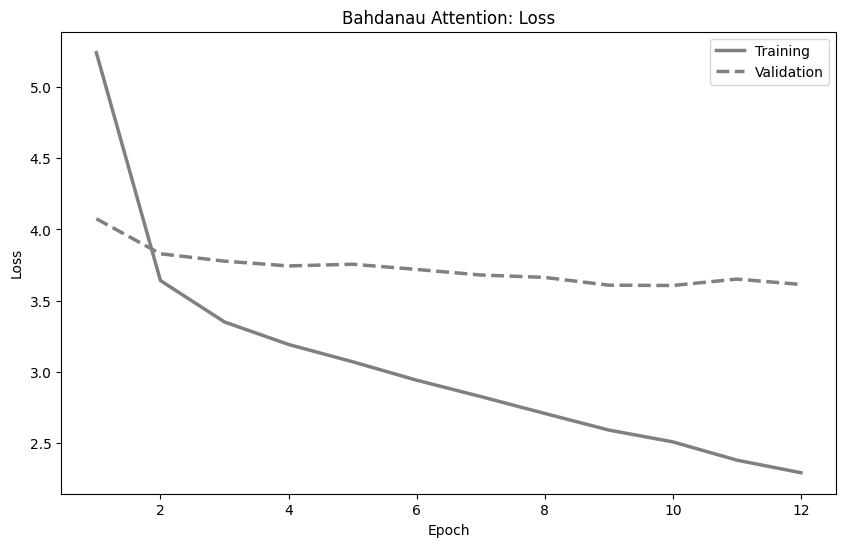

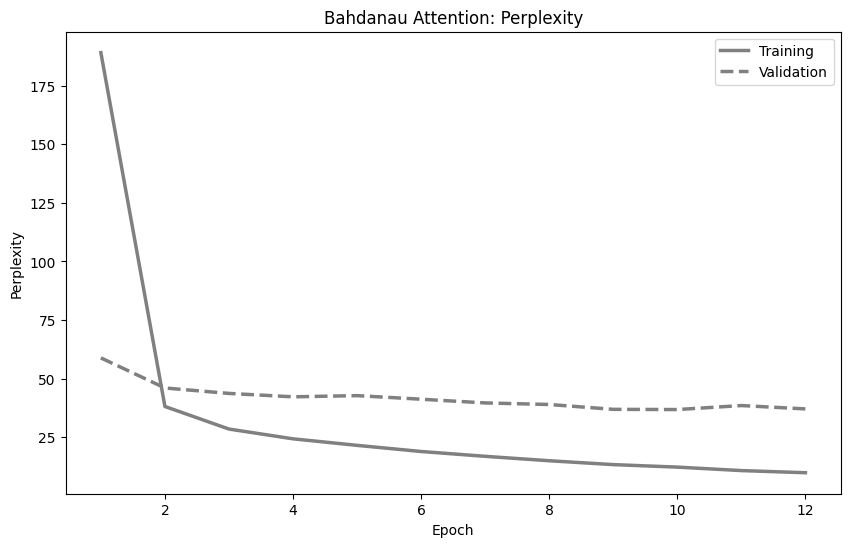

In [235]:
bahdanau_metrics_df = pd.DataFrame(bahdanau_metrics).T

plt.figure(figsize=(10,6))
plt.plot(bahdanau_metrics_df['train_loss'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(bahdanau_metrics_df['valid_loss'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Bahdanau Attention: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(bahdanau_metrics_df['train_ppl'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(bahdanau_metrics_df['valid_ppl'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Bahdanau Attention: Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.show()

In [236]:
best_valid_loss

3.6063316822052003

In [242]:
def predict_text(model, text, device=device, src_vocab=en_vocab, src_tokenizer=en_tokenizer, tgt_vocab=pl_vocab):
    model.eval()
    with torch.no_grad():
        input_ids = [src_vocab[str(token)] for token in src_tokenizer(text)]
        input_ids = [BOS_IDX] + input_ids + [EOS_IDX]
        input_tensor = torch.tensor(input_ids).to(device).unsqueeze(1) # add fake batch dim
        max_len = 2*len(input_ids)
        encoder_outputs, hidden = model.encoder(input_tensor)
        
        output = torch.tensor([BOS_IDX]).to(device)
        
        decoder_outputs = torch.zeros(max_len, 1, len(tgt_vocab)).to(device)
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_len, len(input_ids))
        for t in range(0, max_len):
            output, hidden, attn = model.decoder(output, hidden, encoder_outputs)
            decoder_attentions[t] = attn.data
            decoder_outputs[t] = output
            output = output.argmax(1)
            
            if output.item() == EOS_IDX:
                decoded_words.append('<eos>')
                break
            else:
                decoded_words.append(tgt_vocab.lookup_token(output.item()))
        
        output_sentence = ' '.join(decoded_words)
        return output_sentence, decoder_attentions[:(t+1)]

def show_attention(input_sentence, output_sentence, attentions, figsize=(8,6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='gray')
    fig.colorbar(cax)
    
    src = ['', '<bos>'] + input_sentence.split(' ') + ['<eos>']
    tgt = [''] + output_sentence.split(' ')
    ax.set_xticklabels(src, rotation=90)
    ax.set_yticklabels(tgt)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def predict_and_show_attention(sentence, model, device):
    result, attentions = predict_text(model, sentence, device)
    
    print("Input  >>>", sentence)
    print("Output >>>", result)
    
    show_attention(sentence, result, attentions)

Input  >>> run!
Output >>> nie ! <eos>


/tmp/ipykernel_4646/2634427566.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_4646/2634427566.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(tgt)


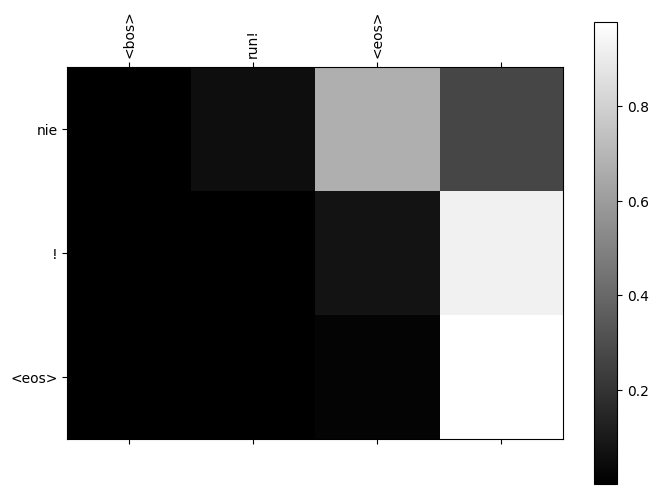

In [251]:
predict_and_show_attention(lines[2][0], seq2seq, device)

## Transformer Encoder-Decoder

In [253]:
def train_transformer(model, iterator, optimizer, loss_fn, device, clip=None):
    model.train()
        
    epoch_loss = 0
    with tqdm(total=len(iterator), leave=False) as t:
        for i, (src, tgt) in enumerate(iterator):
            src = src.to(device)
            tgt = tgt.to(device)
            
            # Create tgt_inp and tgt_out (which is tgt_inp but shifted by 1)
            tgt_inp, tgt_out = tgt[:-1, :], tgt[1:, :]

            tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_inp.size(0)).to(device)
            src_key_padding_mask = (src == PAD_IDX).transpose(0, 1)
            tgt_key_padding_mask = (tgt_inp == PAD_IDX).transpose(0, 1)
            memory_key_padding_mask = src_key_padding_mask.clone()
            
            optimizer.zero_grad()
            
            output = model(src=src, tgt=tgt_inp, 
                           tgt_mask=tgt_mask,
                           src_key_padding_mask = src_key_padding_mask,
                           tgt_key_padding_mask = tgt_key_padding_mask,
                           memory_key_padding_mask = memory_key_padding_mask)
            
            loss = loss_fn(output.view(-1, output.shape[2]),
                           tgt_out.view(-1))
            
            loss.backward()
            
            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optimizer.step()
            epoch_loss += loss.item()
            
            avg_loss = epoch_loss / (i+1)
            t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                          ppl='{:05.3f}'.format(np.exp(avg_loss)))
            t.update()
            
    return epoch_loss / len(iterator)
    
def evaluate_transformer(model, iterator, loss_fn, device):
    model.eval()
        
    epoch_loss = 0
    with torch.no_grad():
        with tqdm(total=len(iterator), leave=False) as t:
            for i, (src, tgt) in enumerate(iterator):
                src = src.to(device)
                tgt = tgt.to(device)
                
                # Create tgt_inp and tgt_out (which is tgt_inp but shifted by 1)
                tgt_inp, tgt_out = tgt[:-1, :], tgt[1:, :]
                
                tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_inp.size(0)).to(device)
                src_key_padding_mask = (src == PAD_IDX).transpose(0, 1)
                tgt_key_padding_mask = (tgt_inp == PAD_IDX).transpose(0, 1)
                memory_key_padding_mask = src_key_padding_mask.clone()

                output = model(src=src, tgt=tgt_inp, 
                               tgt_mask=tgt_mask,
                               src_key_padding_mask = src_key_padding_mask,
                               tgt_key_padding_mask = tgt_key_padding_mask,
                               memory_key_padding_mask = memory_key_padding_mask)
                
                loss = loss_fn(output.view(-1, output.shape[2]),
                               tgt_out.view(-1))
                
                epoch_loss += loss.item()
                
                avg_loss = epoch_loss / (i+1)
                t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                              ppl='{:05.3f}'.format(np.exp(avg_loss)))
                t.update()
    
    return epoch_loss / len(iterator)

In [255]:
transformer = TransformerModel(input_dim=len(en_vocab), 
                             output_dim=len(pl_vocab), 
                             d_model=256, 
                             num_attention_heads=8,
                             num_encoder_layers=6, 
                             num_decoder_layers=6, 
                             dim_feedforward=2048,
                             max_seq_length=32,
                             pos_dropout=0.15,
                             transformer_dropout=0.3)

transformer = transformer.to(device)

/home/jakub/anaconda3/envs/transformers/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [256]:
count_params(transformer)

There are 17,933,935 trainable parameters in this model.


In [257]:
xf_optim = torch.optim.AdamW(transformer.parameters(), lr=1e-4)

In [258]:
%%time
N_EPOCHS = 50
CLIP = 15 # clipping value, or None to prevent gradient clipping
EARLY_STOPPING_EPOCHS = 5
    
model_path = os.path.join(SAVE_DIR, 'transformer_en_fr.pt')
transformer_metrics = {}
best_valid_loss = float("inf")
early_stopping_count = 0
for epoch in tqdm(range(N_EPOCHS), desc="Epoch"):
    train_loss = train_transformer(transformer, train_iter, xf_optim, loss_fn, device, clip=CLIP)
    valid_loss = evaluate_transformer(transformer, valid_iter, loss_fn, device)
    
    if valid_loss < best_valid_loss:
        tqdm.write(f"Checkpointing at epoch {epoch + 1}")
        best_valid_loss = valid_loss
        torch.save(transformer.state_dict(), model_path)
        early_stopping_count = 0
    elif epoch > EARLY_STOPPING_EPOCHS:
        early_stopping_count += 1
    
    transformer_metrics[epoch+1] = dict(
        train_loss = train_loss,
        train_ppl = np.exp(train_loss),
        valid_loss = valid_loss,
        valid_ppl = np.exp(valid_loss)
    )
    
    if early_stopping_count == EARLY_STOPPING_EPOCHS:
        tqdm.write(f"Early stopping triggered in epoch {epoch + 1}")
        break

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]/home/jakub/anaconda3/envs/transformers/lib/python3.12/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Epoch:   2%|▏         | 1/50 [00:15<12:32, 15.36s/it]

Checkpointing at epoch 1


Epoch:   6%|▌         | 3/50 [00:42<10:51, 13.87s/it]

Checkpointing at epoch 3


Epoch:   8%|▊         | 4/50 [00:55<10:19, 13.48s/it]

Checkpointing at epoch 4


Epoch:  10%|█         | 5/50 [01:08<09:54, 13.21s/it]

Checkpointing at epoch 5


Epoch:  12%|█▏        | 6/50 [01:21<09:38, 13.15s/it]

Checkpointing at epoch 6


Epoch:  14%|█▍        | 7/50 [01:33<09:15, 12.93s/it]

Checkpointing at epoch 7


Epoch:  16%|█▌        | 8/50 [01:46<09:04, 12.97s/it]

Checkpointing at epoch 8


Epoch:  18%|█▊        | 9/50 [01:59<08:49, 12.91s/it]

Checkpointing at epoch 9


Epoch:  20%|██        | 10/50 [02:11<08:27, 12.69s/it]

Checkpointing at epoch 10


Epoch:  22%|██▏       | 11/50 [02:24<08:10, 12.58s/it]

Checkpointing at epoch 11


Epoch:  24%|██▍       | 12/50 [02:37<08:05, 12.77s/it]

Checkpointing at epoch 12


Epoch:  30%|███       | 15/50 [03:13<07:11, 12.32s/it]

Checkpointing at epoch 15


Epoch:  32%|███▏      | 16/50 [03:26<07:05, 12.51s/it]

Checkpointing at epoch 16


Epoch:  36%|███▌      | 18/50 [03:51<06:39, 12.49s/it]

Checkpointing at epoch 18


Epoch:  44%|████▍     | 22/50 [04:53<06:12, 13.32s/it]

Early stopping triggered in epoch 23
CPU times: user 1h 7min 22s, sys: 20.9 s, total: 1h 7min 43s
Wall time: 4min 53s


In [259]:
transformer.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

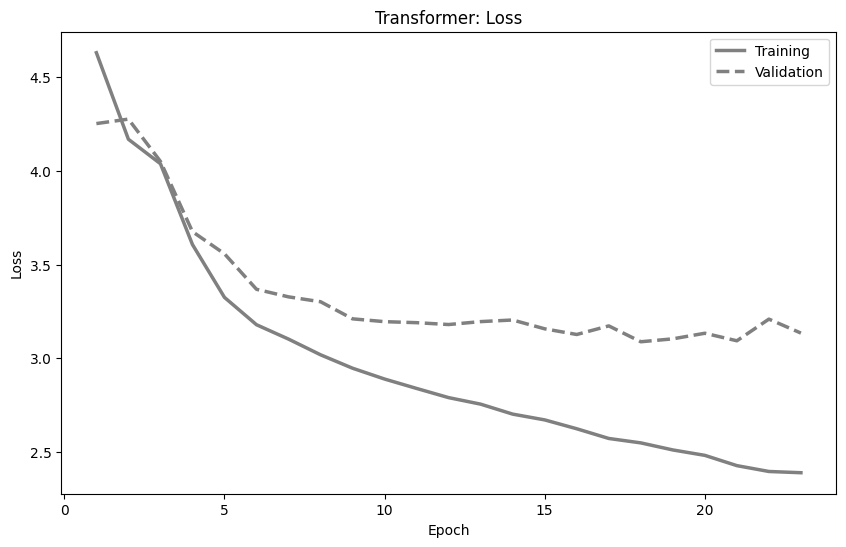

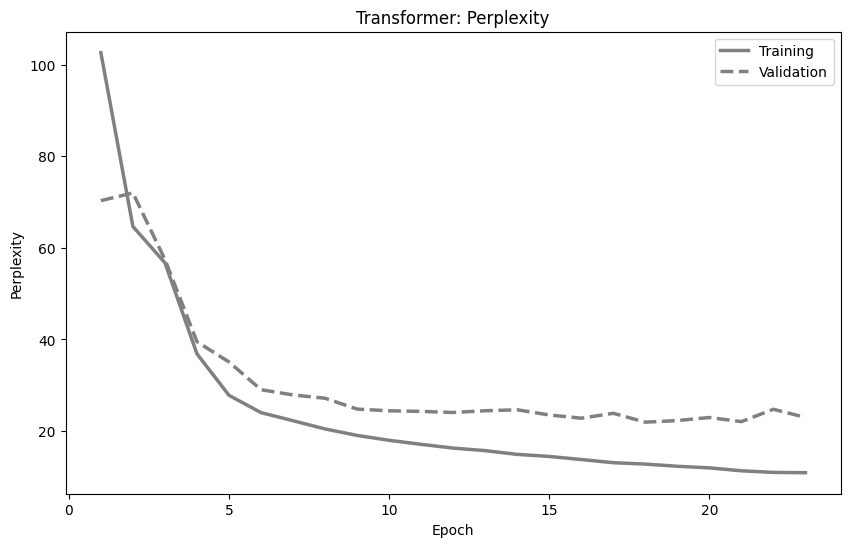

In [260]:
transformer_metrics_df = pd.DataFrame(transformer_metrics).T

plt.figure(figsize=(10,6))
plt.plot(transformer_metrics_df['train_loss'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(transformer_metrics_df['valid_loss'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Transformer: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(transformer_metrics_df['train_ppl'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(transformer_metrics_df['valid_ppl'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Transformer: Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.show()

In [261]:
best_valid_loss

3.088576602935791

In [266]:
def predict_transformer(text, model, 
                        src_vocab=en_vocab, 
                        src_tokenizer=en_tokenizer, 
                        tgt_vocab=pl_vocab, 
                        device=device):
    
    input_ids = [src_vocab[str(token)] for token in src_tokenizer(text)]
    input_ids = [BOS_IDX] + input_ids + [EOS_IDX]
    
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_ids).to(device).unsqueeze(1) # add fake batch dim
        
        causal_out = torch.ones(MAX_SENTENCE_LENGTH, 1).long().to(device) * BOS_IDX
        for t in range(1, MAX_SENTENCE_LENGTH):
            decoder_output = transformer(input_tensor, causal_out[:t, :])[-1, :, :]
            next_token = decoder_output.data.topk(1)[1].squeeze()
            causal_out[t, :] = next_token
            if next_token.item() == EOS_IDX:
                break
                
        pred_words = [tgt_vocab.lookup_token(tok.item()) for tok in causal_out.squeeze(1)[1:(t)]]
        return " ".join(pred_words)

In [272]:
for i in range(10):
    print('Original:', lines[i][0])
    print('Output:', predict_transformer(lines[i][0], transformer), '\n')

Original: go.
Output: nie nie idz . 

Original: hi.
Output: nie idz . 

Original: run!
Output: nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie 

Original: run.
Output: prosze sie 

Original: run.
Output: prosze sie 

Original: who?
Output: kto ? 

Original: wow!
Output: nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie 

Original: wow!
Output: nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie 

Original: duck!
Output: nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie 

Original: fire!
Output: nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie nie 

